<h1> Assignment of week 3 </h1>

In [12]:
#!pip install folium
#!pip install wget
#!pip install arcgis

'3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]'

In [95]:
import requests
import csv
import lxml.html as lh
from bs4 import BeautifulSoup
import pandas as pd
from arcgis.gis import GIS
import urllib
from geopy.geocoders import Nominatim
import folium # map rendering library
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from pandas.io.json import json_normalize
import wget
from sklearn.preprocessing import MinMaxScaler

<h3> Beatiful soup use, for scraping wikipedia table </h3>

In [14]:
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(URL)
html = BeautifulSoup(page.text, 'html.parser')
table = html.findAll('table',{"class":"sortable"})[0]
end_col = len(table.findAll('th'))
end_row = len(table.findAll('tr'))

<h3> Extract data with html tags and append them to table </h3>

In [15]:
data=[]
start_col = 0
start_row = 1   
tr = table.findAll(['tr'])[start_row:end_row]
th = table.find_all(['th'])[start_col:end_col]
th_data = [col.text.strip('\n') for col in th]
for cell in tr:
    td = cell.find_all('td')
    row = [i.text.replace('\n','') for i in td]
    if row[1] != "Not assigned":
        data.append(row)

<h3> Create df and check how it looks using head method aswell as a shape attribute<h3>

In [16]:
df = pd.DataFrame(data)
df
df.columns = th_data
df.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
print(df.head())
print()
print("Shape of our df", df.shape)

  PostalCode           Borough                                Neighbourhood
0        M3A        North York                                    Parkwoods
1        M4A        North York                             Victoria Village
2        M5A  Downtown Toronto                    Regent Park, Harbourfront
3        M6A        North York             Lawrence Manor, Lawrence Heights
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

Shape of our df (103, 3)


<h3> Getting coordinates based on Postal code, using cocl.us link </h3>

In [17]:
df_coordinates = pd.read_csv('http://cocl.us/Geospatial_data')
df_coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
df_coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


<h3> Merge of df and df_coordinates DataFrames, creating new df - df_ </h3>

In [18]:
df_ = pd.merge(df, df_coordinates, on='PostalCode', how='left')
df_.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


<h3> Drop all rows where Borough not containing Toronto </h3>

In [19]:
df_toronto = df_[df_['Borough'].str.contains('Toronto')].reset_index(drop=True)
df_toronto.head()
df_toronto['Latitude']

0     43.654260
1     43.662301
2     43.657162
3     43.651494
4     43.676357
5     43.644771
6     43.657952
7     43.669542
8     43.650571
9     43.669005
10    43.640816
11    43.647927
12    43.679557
13    43.647177
14    43.636847
15    43.668999
16    43.648198
17    43.659526
18    43.728020
19    43.711695
20    43.712751
21    43.696948
22    43.661608
23    43.715383
24    43.672710
25    43.648960
26    43.704324
27    43.662696
28    43.651571
29    43.689574
30    43.653206
31    43.686412
32    43.628947
33    43.679563
34    43.646435
35    43.667967
36    43.648429
37    43.665860
38    43.662744
Name: Latitude, dtype: float64

<h3> Map of Toronto using folium library </h3>

In [25]:

latitude = 43.651070
longitude = -79.347015
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighbourhood in zip(df_toronto['Latitude'], df_toronto['Longitude'],df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(borough, neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<h3> Forsquare Credentials and version <h3>

CLIENT_ID = 'G5MSLDJ2TJ3CBTFPY1WCHFSJR3NLNW33OQNWEO22I5WI51XM' # your Foursquare ID
CLIENT_SECRET = 'FSUUFCL333NOLHGIRRMPXAYSAN4SLT2WKDYLN2A4GHWFH2LU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

<h3> Exploring the first neighborhood in df </h3>
let's remind how our df looks like

In [32]:
df_toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Name of first neighborhood

In [34]:
df_toronto.loc[0,'Neighbourhood']

'Regent Park, Harbourfront'

Gets first neighborhood data

In [36]:
neighborhood_latitude = df_toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_toronto.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


<h3> Get details about neighborhood using forsquare api </h3>

In [37]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=G5MSLDJ2TJ3CBTFPY1WCHFSJR3NLNW33OQNWEO22I5WI51XM&client_secret=FSUUFCL333NOLHGIRRMPXAYSAN4SLT2WKDYLN2A4GHWFH2LU&v=20180605&ll=43.6542599,-79.3606359&radius=500&limit=100'

<h3> Get results in json format

In [43]:
results = requests.get(url).json()
#result too much space :) 

Defining Function that extracts the category of the venue

In [44]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean json variable and convert into dataframe using pandas

In [48]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Impact Kitchen,Restaurant,43.656369,-79.356980


In [51]:
print('venues returned from forsquare database: {}'.format(nearby_venues.shape[0]))

venues returned from forsquare database: 45


<h2> Explore all Neighborhoods in Toronto

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    """
    Function to repeat above cells process to
    get all venues for every neighborhood in 
    our dataframe    
    """
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h3> Use of function above

In [55]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


Check result

In [58]:
print(toronto_venues.shape)
toronto_venues.head()

(1631, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


Count venues for each neighborhood

In [64]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,64,64,64,64,64,64
Christie,16,16,16,16,16,16
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


In [66]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


<h2> Analyze each neighborhood

In [75]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()


,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h4>Group rows by neighborhood and by taking the mean of the frequency of occurence of each category

In [76]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.017241,0.000000,0.000000,0.000000,0.00
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
4,Central Bay Street,0.015625,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.015625,0.000000,0.000000,0.015625,0.00
5,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
6,Church and Wellesley,0.025974,0.012987,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.012987,...,0.012987,0.012987,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.040000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.00
8,Davisville,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.000000,0.000000,0.030303,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
9,Davisville North,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00


<h3> Neighborhoods with Top5 most common venues

In [77]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.10
1                Café  0.03
2  Seafood Restaurant  0.03
3         Cheese Shop  0.03
4        Cocktail Bar  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1          Bakery  0.09
2  Breakfast Spot  0.09
3     Coffee Shop  0.09
4    Climbing Gym  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0    Light Rail Station  0.12
1  Gym / Fitness Center  0.06
2         Garden Center  0.06
3                  Park  0.06
4           Pizza Place  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0      Airport Service  0.19
1       Airport Lounge  0.12
2     Airport Terminal  0.12
3  Rental Car Location  0.06
4             Boutique  0.06


----Central Bay Street----
                ve

Create new pandas df

In [78]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Top10 venues for each neighborhood

In [79]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Farmers Market,Beer Bar,Cocktail Bar,Bakery,Seafood Restaurant,Cheese Shop,Restaurant,Café,Diner
1,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Breakfast Spot,Coffee Shop,Pet Store,Bar,Intersection,Restaurant,Italian Restaurant,Burrito Place
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Gym / Fitness Center,Fast Food Restaurant,Farmers Market,Auto Workshop,Restaurant,Burrito Place,Pizza Place,Comic Shop,Park
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Coffee Shop,Boat or Ferry,Rental Car Location,Sculpture Garden,Harbor / Marina,Boutique,Airport Gate
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Bubble Tea Shop,Burger Joint,Japanese Restaurant,Department Store,Yoga Studio


<h2> Cluster neighborhoods

Check best number of clusters with elbow method

In [110]:
distortions = []
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    

Plot the disortions of k-means

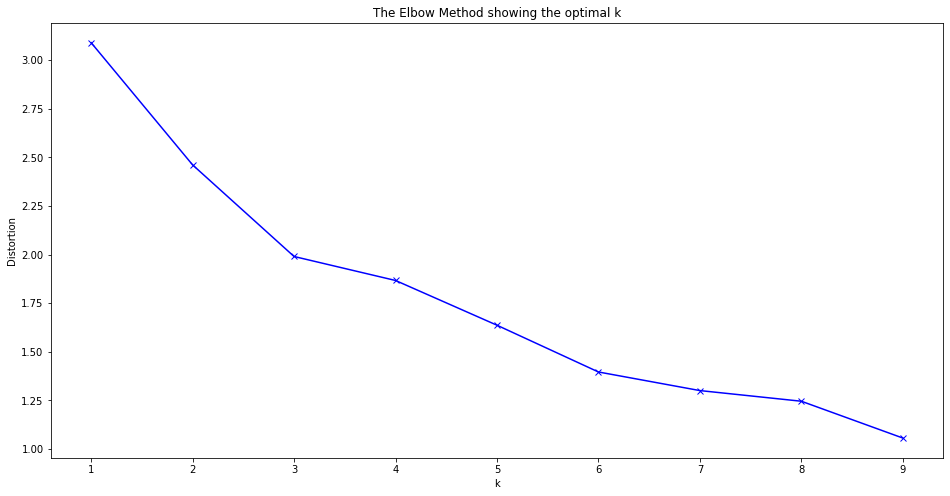

In [111]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [112]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [120]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

neighborhoods_venues_sorted

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged # check the last columns!


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Spa,Ice Cream Shop,Beer Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Diner,Yoga Studio,College Auditorium,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,Portuguese Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Pizza Place
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Café,Restaurant,Coffee Shop,Clothing Store,American Restaurant,Cosmetics Shop,Cocktail Bar,Diner,Farmers Market,Breakfast Spot
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Trail,Health Food Store,Women's Store,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Discount Store
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Farmers Market,Beer Bar,Cocktail Bar,Bakery,Seafood Restaurant,Cheese Shop,Restaurant,Café,Diner
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Bubble Tea Shop,Burger Joint,Japanese Restaurant,Department Store,Yoga Studio
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2,Grocery Store,Café,Park,Diner,Restaurant,Candy Store,Italian Restaurant,Nightclub,Coffee Shop,Baby Store
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Gym,Steakhouse,Bar,Thai Restaurant,Pizza Place
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2,Pharmacy,Bakery,Park,Café,Bank,Bar,Middle Eastern Restaurant,Brewery,Supermarket,Music Venue


Visualize the result of clustering

In [121]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2> Examine Clusters

<h5> Cluster 1

In [122]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,0,Pub,Trail,Health Food Store,Women's Store,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Discount Store
18,Central Toronto,0,Park,Swim School,Bus Line,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner
21,Central Toronto,0,Park,Jewelry Store,Trail,Sushi Restaurant,Cuban Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
29,Central Toronto,0,Park,Lawyer,Trail,Tennis Court,Cuban Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
33,Downtown Toronto,0,Park,Trail,Playground,Creperie,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner


<h5> Cluster 2

In [123]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,1,Garden,Music Venue,Women's Store,Cupcake Shop,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


<h5> Cluster 3

In [124]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,2,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Spa,Ice Cream Shop,Beer Store
1,Downtown Toronto,2,Coffee Shop,Diner,Yoga Studio,College Auditorium,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,Portuguese Restaurant
2,Downtown Toronto,2,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Pizza Place
3,Downtown Toronto,2,Café,Restaurant,Coffee Shop,Clothing Store,American Restaurant,Cosmetics Shop,Cocktail Bar,Diner,Farmers Market,Breakfast Spot
5,Downtown Toronto,2,Coffee Shop,Farmers Market,Beer Bar,Cocktail Bar,Bakery,Seafood Restaurant,Cheese Shop,Restaurant,Café,Diner
6,Downtown Toronto,2,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Bubble Tea Shop,Burger Joint,Japanese Restaurant,Department Store,Yoga Studio
7,Downtown Toronto,2,Grocery Store,Café,Park,Diner,Restaurant,Candy Store,Italian Restaurant,Nightclub,Coffee Shop,Baby Store
8,Downtown Toronto,2,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Gym,Steakhouse,Bar,Thai Restaurant,Pizza Place
9,West Toronto,2,Pharmacy,Bakery,Park,Café,Bank,Bar,Middle Eastern Restaurant,Brewery,Supermarket,Music Venue
10,Downtown Toronto,2,Coffee Shop,Aquarium,Café,Hotel,Restaurant,Fried Chicken Joint,Scenic Lookout,Brewery,Plaza,Pizza Place


<h3> Rename clusters names

In [129]:
toronto_merged['Cluster Labels'].replace(0, 'Nearby Parks', inplace=True)
toronto_merged['Cluster Labels'].replace(1, 'Quiet neigberhood', inplace=True)
toronto_merged['Cluster Labels'].replace(2, 'Nearby popular places', inplace=True)
toronto_merged

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Nearby popular places,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Spa,Ice Cream Shop,Beer Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Nearby popular places,Coffee Shop,Diner,Yoga Studio,College Auditorium,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,Portuguese Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,Nearby popular places,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Pizza Place
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,Nearby popular places,Café,Restaurant,Coffee Shop,Clothing Store,American Restaurant,Cosmetics Shop,Cocktail Bar,Diner,Farmers Market,Breakfast Spot
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,Nearby Parks,Pub,Trail,Health Food Store,Women's Store,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Discount Store
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,Nearby popular places,Coffee Shop,Farmers Market,Beer Bar,Cocktail Bar,Bakery,Seafood Restaurant,Cheese Shop,Restaurant,Café,Diner
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Nearby popular places,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Bubble Tea Shop,Burger Joint,Japanese Restaurant,Department Store,Yoga Studio
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,Nearby popular places,Grocery Store,Café,Park,Diner,Restaurant,Candy Store,Italian Restaurant,Nightclub,Coffee Shop,Baby Store
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,Nearby popular places,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Gym,Steakhouse,Bar,Thai Restaurant,Pizza Place
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,Nearby popular places,Pharmacy,Bakery,Park,Café,Bank,Bar,Middle Eastern Restaurant,Brewery,Supermarket,Music Venue


<h2> Profiles for clusters

- Cluster 0, Nearby Parks
- Cluster 1, Quiet neighboorhood
- Cluster 2, Popular places